In [1]:
import numpy as np

import cv2
import sys
import torch

# from effdet import create_model_from_config
from hydra.utils import instantiate
from omegaconf import OmegaConf
from PIL import Image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../src')

In [3]:
from train import create_dataset
from data.loader import fast_collate
from data.sampler import CustomSampler
from models.efficient_det import create_model_from_config
from utils.visualize import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [4]:
def draw_bboxes(image, bboxes, color, box_format='coco', yxyx=False):
    if yxyx:
        # yxyx -> xyxy
        bboxes = bboxes[:, [1,0,3,2]]
        
    bboxes = bboxes.astype(int)
    
    for box in bboxes:
        pt1 = tuple(box[:2])
        if box_format == 'coco':
            pt2 = tuple(box[:2] + box[2:])
        elif box_format == 'pascal_voc':
            pt2 = tuple(box[2:])
        else:
            raise AttributeError("Lel, kek, no {} for you :p".format(box_format))
            
        cv2.rectangle(image, pt1, pt2, color, 1)

In [5]:
conf = OmegaConf.load('../config/train.yaml')
target_yxyx = conf.data.train.params.box_format == 'yxyx'

In [6]:
ds = create_dataset(conf.data.train, conf.data.train.transforms, show_progress=True)

Parsing bboxes...:   0%|          | 0/2793 [00:00<?, ?it/s]

Loading train data...


Parsing bboxes...: 100%|██████████| 2793/2793 [00:17<00:00, 161.20it/s]

train: 27781 images


In [7]:
# dl = torch.utils.data.DataLoader(ds, batch_size=6, shuffle=False, collate_fn=fast_collate)

In [8]:
sampler = CustomSampler(ds)
dl = torch.utils.data.DataLoader(ds, sampler=sampler, batch_size=6, collate_fn=fast_collate)

In [9]:
# i = 0
# score_thresh = 0.05

# preds = predictions[i, :, :]
# preds = preds[preds[:, 4] >= score_thresh, :4]
# print(preds.shape)

# preds = preds / targets_gpu['img_scale'][i]
# preds = preds.cpu().numpy()

# image = images_gpu[i] * std[0] + mean[0]
# image = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# target_yxyx = conf.data.train.params.box_format == 'yxyx'
# draw_bboxes(image, targets['bbox'][i], (255, 0, 0), box_format='pascal_voc', yxyx=target_yxyx)
# draw_bboxes(image, preds, (0, 255, 0), box_format='coco')

# plt.figure(figsize=(18, 18))
# plt.imshow(image)

In [10]:
def mosaic_yxyx(mos_size, img_size):
    orig_hw = np.concatenate([img_size, img_size], axis=-1).astype(np.int)
    g1 = np.array([
        [-1, -1,  0,  0],
        [ 0, -1,  1,  0],
        [-1,  0,  0,  1],
        [ 0,  0,  1,  1]
    ])
    
    g2 = np.array([
        [1, 1, 1, 1],
        [0, 1, 1, 1],
        [1, 0, 1, 1],
        [0, 0, 1, 1]
    ])
    
    a = g1 * orig_hw
    
    H, W = mos_size
    mos_hw = np.ones_like(g1) * np.array([H, W, H, W], dtype=np.int)
    
    mos_yx = g1 * orig_hw + mos_hw // 2
    mos_yx[:, [0, 2]] = np.clip(mos_yx[:, [0, 2]], 0, H)
    mos_yx[:, [1, 3]] = np.clip(mos_yx[:, [1, 3]], 0, W)
    
    slice_hw = mos_yx[:, 2:] - mos_yx[:, :2]
    slice_hw = np.concatenate([slice_hw] * 2, axis=1)
    
    inp_yx = (g1 * slice_hw) + (g2 * orig_hw)
    inp_yx[:, 2] = np.clip(inp_yx[:, 2], 0, inp_yx[:, 0] + slice_hw[:, 2])
    inp_yx[:, 3] = np.clip(inp_yx[:, 3], 0, inp_yx[:, 1] + slice_hw[:, 3])
    
    offset_yx = mos_yx[:, :2] - inp_yx[:, :2]
    
    return mos_yx, inp_yx, offset_yx



def build_mosaic(shape, images, targets, target_yxyx=False):
    assert len(images) == 4
    
    H, W, C = shape    
    img_sizes = np.stack([img.shape[:2] for img in images])
    mos_yx, img_yx, off_yx = mosaic_yxyx((H, W), img_sizes)
    
    mosaic = np.zeros(shape, dtype=np.uint8)
    mos_boxes = []
    mos_cls = []

    for i in range(4):
        image = images[i]
        target = targets[i]
        offset = off_yx[i]

        if not target_yxyx:
            offset = offset[::-1]
            
        boxes = target['bbox'] + np.concatenate([offset] * 2)

        y0m, x0m, y1m, x1m = mos_yx[i]
        y0i, x0i, y1i, x1i = img_yx[i]
        print("{}: ({:4d}, {:4d}), ({:4d}, {:4d})".format(i, x0m, y0m, x1m, y1m))
        print("{}: ({:4d}, {:4d}), ({:4d}, {:4d})".format(i, x0i, y0i, x1i, y1i))

        mosaic[y0m:y1m, x0m:x1m] = image[y0i:y1i, x0i:x1i]
        mos_boxes.append(boxes)
        mos_cls.append(target['cls'])
    
    mos_target = dict(
        bbox=np.concatenate(mos_boxes), 
        cls=np.concatenate(mos_cls))
    
    return mosaic, mos_target

0: (   0,    0), ( 750,  750)
0: (  18,   18), ( 768,  768)
1: (   0,  750), ( 750, 1500)
1: (  18,    0), ( 768,  750)
2: ( 750,    0), (1500,  750)
2: (   0,   18), ( 750,  768)
3: ( 750,  750), (1500, 1500)
3: (   0,    0), ( 750,  750)


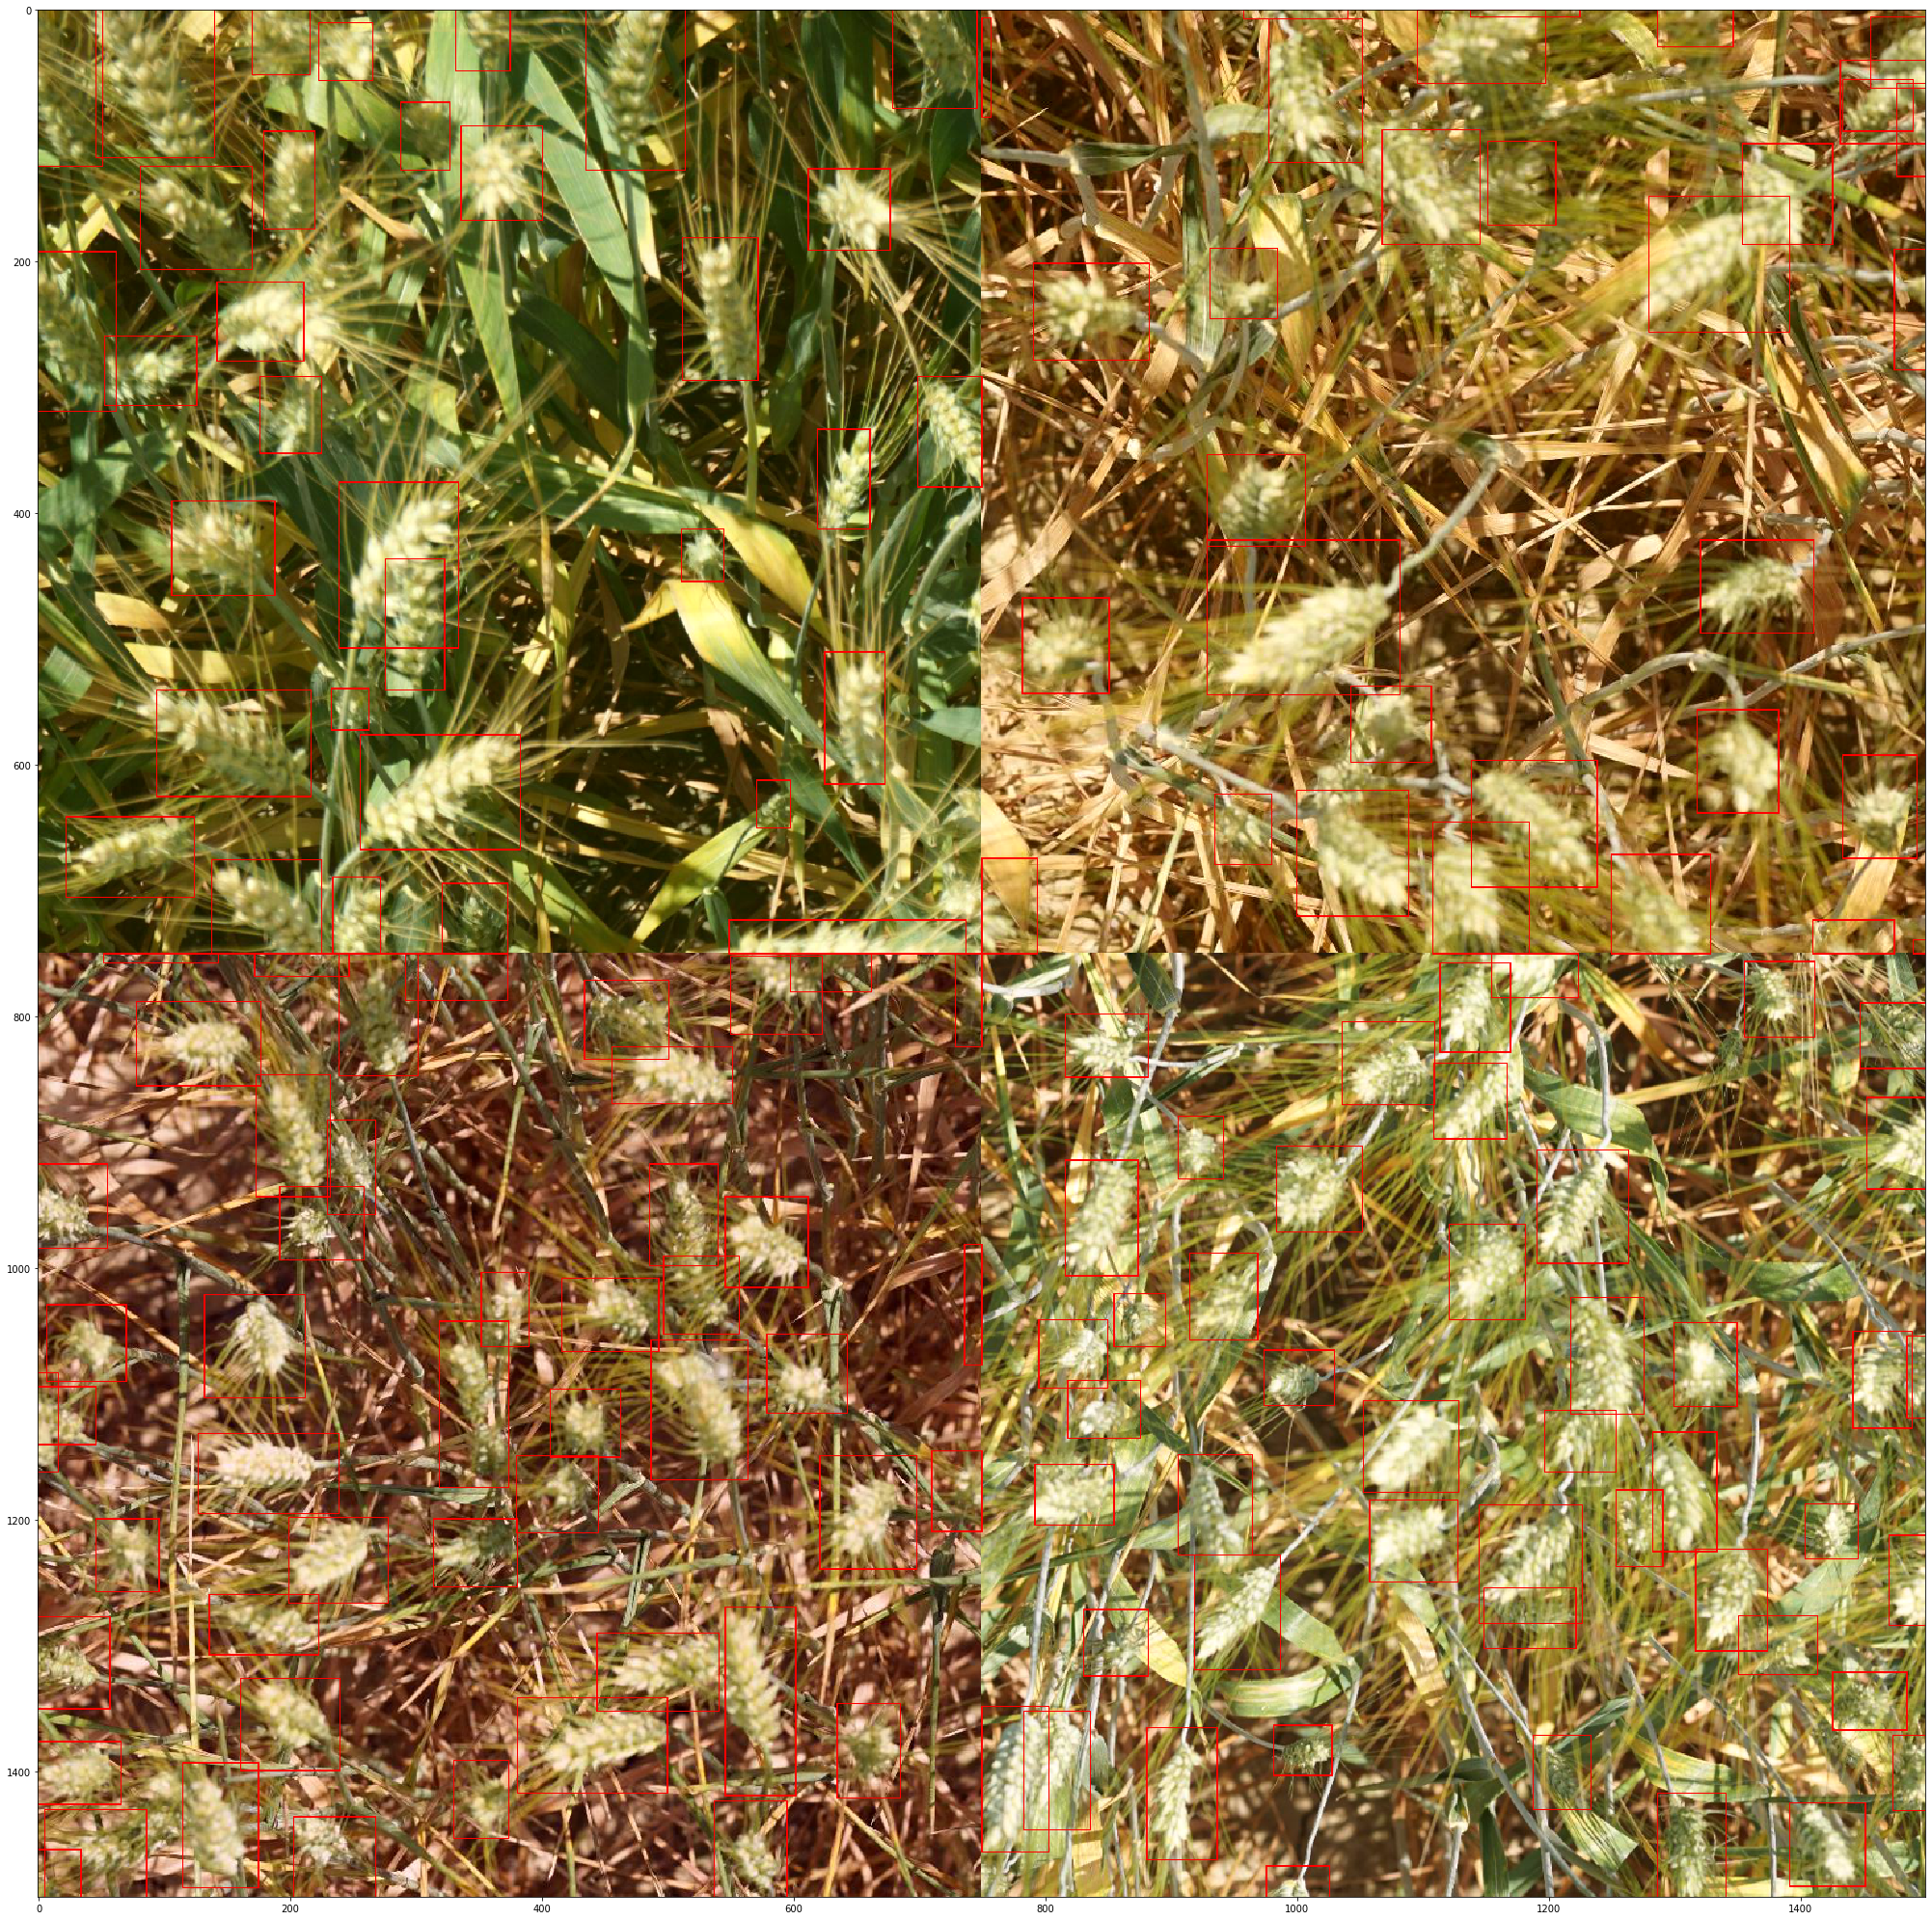

In [11]:
start_idx = 400
images, targets = [], []

for i in range(start_idx, start_idx + 4):
    img, tg = ds[i]
    img = img.transpose((1, 2, 0))
    images.append(img)
    targets.append(tg)
    
mosaic, mos_target = build_mosaic((1500, 1500, 3), images, targets, target_yxyx=target_yxyx)

draw_bboxes(mosaic, mos_target['bbox'], 
            color=(255, 0, 0), 
            box_format='pascal_voc', 
            yxyx=target_yxyx)

plt.figure(figsize=(36, 36))
plt.imshow(mosaic)

In [13]:
img_sizes = [
    (30, 150),
    (75, 75),
    (50, 100),
    (120, 50)
]

mosaic_yxyx((200, 200), np.array(img_sizes))

(array([[ 70,   0, 100, 100],
        [100,  25, 175, 100],
        [ 50, 100, 100, 200],
        [100, 100, 200, 150]]),
 array([[  0,  50,  30, 150],
        [  0,   0,  75,  75],
        [  0,   0,  50, 100],
        [  0,   0, 100,  50]]),
 array([[ 70, -50],
        [100,  25],
        [ 50, 100],
        [100, 100]]))

In [14]:
img_sizes = [
    (300, 150),
    (80, 95),
    (80, 120),
    (120, 320)
]

mosaic_yxyx((200, 200), np.array(img_sizes))

(array([[  0,   0, 100, 100],
        [100,   5, 180, 100],
        [ 20, 100, 100, 200],
        [100, 100, 200, 200]]),
 array([[200,  50, 300, 150],
        [  0,   0,  80,  95],
        [  0,   0,  80, 100],
        [  0,   0, 100, 100]]),
 array([[-200,  -50],
        [ 100,    5],
        [  20,  100],
        [ 100,  100]]))